# Account for Familiy structure using Permutation testing
This Python code is a conversion of a portion of the PALM (Permutation Analysis of Linear Models) package, initially created by Anderson M. Winkler. 
PALM serves as a robust tool for conducting permutation-based statistical analyses.
If you wish to explore PALM further, please refer to the official [PALM website](http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/PALM) or read their guidelines on how the [exchangeable blocks](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/PALM/ExchangeabilityBlocks) are created in MATLAB

In this Python adaptation, our primary focus lies in accommodating family structure within your dataset. 
We implement methods in PALM that manage exchangeability blocks, which is described in:  
* Winkler AM, Webster MA, Vidaurre D, Nichols TE, Smith SM. Multi-level block permutation. Neuroimage. 2015;123:253-68. (Available as Open Access). DOI: 10.1016/j.neuroimage.2015.05.092



In this tutorial, we will walk through a practical example of processing family-related data using the Human Connectome Project dataset in Python. 

Performing permutation tests with HCP data involves working with an ```EB.csv``` (Exchangeability Block) file, which is structured with multiple columns. 
These columns define blocks for each family, allowing for entire families to be shuffled collectively, and within these families, individual subjects can be permuted. 
Creating this file while considering the kinship relationships among hundreds of HCP subjects would be a time-consuming and error-prone task and can be construced using the function ```hcp2block``` from ```palm_functions.py```. 
To utilize it, follow these steps:

1. Ensure that you have obtained the necessary permissions to access restricted HCP data. If you haven't obtained permission yet, please follow the instructions provided on the [HCP website](https://www.humanconnectome.org/).

2. Once you have obtained permission, download the most up-to-date version of the restricted data file. This file is typically in CSV format and will be named something like ```RESTRICTED_yourname_MM_DD_YY_HH_MM_SS.csv``` after downloading.


## Table of Contents
1. [Explore data](#ex-data)
2. [Create Exchangeability blocks](#EB)
3. [Re-index EB](#EB-re)
4. [PALM tree](#Palm)
5. [Shuffle Permutation Tree](#Ptree-shuf)
6. [Run quick-perm function](#Ptree-quick)


### Import libraries
Let's start by importing the required libraries and modules.

In [ ]:
import numpy as np
import pandas as pd
from palm_functions import hcp2block 

## 1. Explore Data <a id="ex-data"></a>
Here we are going to look the data from the ```RESTRICTED_yourname_MM_DD_YY_HH_MM_SS.csv```

In [6]:
# Sample data - Replace this with your actual data
# famid, sibtype, famtype, age
# Load data
file_path = "RESTRICTED_yourname_MM_DD_YY_HH_MM_SS.csv"
twin_data = pd.read_csv(file_path)

In [7]:
print("\nSummary statistics:")
print(twin_data.describe())


Summary statistics:
             Subject   Age_in_Yrs     Mother_ID     Father_ID  \
count    1206.000000  1206.000000   1206.000000   1206.000000   
mean   374551.585406    28.837479  53110.315920  83166.267828   
std    272686.898230     3.690534   3464.007126   3075.715552   
min    100004.000000    22.000000  50263.000000  80216.000000   
25%    154254.250000    26.000000  51603.000000  81476.000000   
50%    212166.500000    29.000000  52312.000000  82201.000000   
75%    586310.500000    32.000000  53302.250000  84431.000000   
max    996782.000000    37.000000  99998.000000  99999.000000   

       TestRetestInterval   Handedness  SSAGA_Employ  SSAGA_Income  \
count           46.000000  1206.000000   1204.000000   1199.000000   
mean           139.304348    65.621891      1.521595      5.003336   
std             68.994000    44.994546      0.749862      2.172830   
min             18.000000  -100.000000      0.000000      1.000000   
25%             95.000000    60.000000     

## 2. Create Exchangeability blocks <a id="EB"></a>

Now after looking at the ```RESTRICTED_yourname_MM_DD_YY_HH_MM_SS.csv``` we can create the exchangeability blocks (```EB```) by using the ```hcp2block``` function. Having ```EB``` makes it possible to create the Permutation Tree (```Ptree```)

In [5]:
import os
# Filter twin_data
folder_name = "data"
data_ID_file = 'data_ID.npy'

# Load behavioral data
file_path = os.path.join(folder_name, data_ID_file)
data_ID = np.load(file_path)

# Filter the twin data
twin_data_filtered = twin_data[twin_data['Subject'].isin(data_ID)]
twin_data_filtered.shape

(1003, 201)

In [5]:
# Example usage
blocksfile = "EB.csv"
tab, EB, famtype = hcp2block(twin_data_filtered, blocksfile, dz2sib=False)

c:\Users\au323479\Desktop\permtest\PALM-master_python\palm_functions.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Zygosity'] = np.where(tmp['ZygosityGT'].isna() | (tmp['ZygosityGT'] == ' ') | tmp['ZygosityGT'].isnull(),


These subjects have data missing and will be removed: [168240, 376247]


**Data Transformation Results**\
Display the results of using the function on the HCP twin data.

In [6]:
# Display transformed data and results
print("Original tab shape:", twin_data.shape)
print("Transformed tab shape:", tab.shape)
print("Block structure shape:", EB.shape)
print("Family type array shape:", famtype.shape)

Original tab shape: (1206, 201)
Transformed tab shape: (1001, 6)
Block structure shape: (1001, 5)
Family type array shape: (1001,)


The steps above will generate a file named ```EB.csv```. This file contains definitions for blocks corresponding to subjects with complete family information in the restricted file.
 
Complete family information means subjects with both father and mother IDs, along with zygosity information. The order of these definitions in ```EB.csv``` mirrors the order of subjects in the restricted file. 

We'll use the data from ```EB``` to create a Permutation Tree (```Ptree```) that we can later use for permutation testing.\
 When we examine the ```EB``` data, we can interpret its different columns as follows:
* 1st col: The negative values in this column indicate that the sub-indices in the next column must remain unchanged during shuffling.
* 2nd col: familie type, which is a calculated score assigned to each family. For example, a family consisting of a mother, father, 1 full sibling (FS), and 2 monozygotic twins (MZ) would have same score as other families with the same family combination.
* 3rd col: family ID, providing a distinct identifier for each family.
* 4th col: sibling type, which represents the score assigned to each subject.
* 5th col: subject ID, which are unique identifiers for each subject in the dataset.

Regarding permutations, dizygotic twins (DZ) can be handled differently from non-twins (NT). By default, DZ twins cannot be shuffled with non-twin subjects, even within the same family. However, since DZ pairs share the same kinship as NT siblings, you might want to allow them to be swapped during permutations. You can provide a third argument as 'true' to hcp2blocks to indicate this.

In [7]:
pd.DataFrame(EB).head()

,0,1,2,3,4
0,-1,2012,-419,10,100206
1,-1,2012,-78,1000,100307
2,-1,2012,-135,1000,100408
3,-1,212,-288,100,100610
4,-1,2002,9,1000,101006


## 3.Re-index EB <a id="EB-re"></a>
The function  ```palm_reindex(EB, 'fixleaves')``` is responsible for reindexing or restructuring the input data in a way that is suitable for palm tree shuffling analysis. It restructures the input data ```EB``` into the appropriate palm tree structure, focusing on correctly organizing leaf nodes for subsequent shuffling operations. This ensures data consistency, accuracy, and meaningful results during shuffling analysis, making it an essential step in the overall process.


The ```palm_reindex(EB, 'fixleaves')``` accepts the following parameters:
* ```EB```: EB represents the input data that you want to analyze using palm tree shuffling. This data likely has a specific structure or format that needs to be converted to a palm tree structure.

* ```'fixleaves' Argument```: The second argument 'fixleaves' specifies the method used for reindexing the input data. In this case, the method is 'fixleaves', which suggests that the function will address issues related to leaf nodes or leaves within the palm tree structure.

The importance of this reindixing ```EB```
1. Palm Tree Structure: Palm tree shuffling analysis typically works with data organized in a palm tree structure. A palm tree structure is a hierarchical structure where each node has child nodes. This structure is used to represent data that can be shuffled or permuted.

2. Leaf Nodes: In palm tree structures, leaf nodes represent the individual data elements that can be shuffled or permuted. These are often the "leaves" of the tree, and they need to be correctly organized for shuffling operations.

3. 'fixleaves' Method: The 'fixleaves' method is specifically designed to handle the reindexing of leaf nodes. It ensures that the leaf nodes are correctly organized and ready for shuffling.




In [8]:
from palm_functions import  palm_reindex
# Example usage:
EB_idx = palm_reindex(EB, "fixleaves") 

## 4. PALM tree <a id="Palm"></a>
The palm_tree function in the context of the provided code is used to create a palm tree structure from reindexed exchangeable blocks (```EB```) and an optional design matrix (```M```). This function provides a structured way to understand and visualize the the relationships and hierarchies within the data. The specific details of the palm tree construction may vary depending on the context of your analysis and the structure of your data.

The ```palm_tree(EB, M)``` accepts the following parameters:
* ```EB```: EB represents the Reindexed Exchangeable Blocks. This input represents a data structure where the exchangeable blocks are reordered and indexed in a specific way. The exact format and structure of EB depend on the specific context of your analysis.

* ```'M (Optional)```': ```M``` represents the Design Matrix. It is used to represent the relationships between variables.


The palm tree structure captures the hierarchical relationships among exchangeable blocks and variables represented by

In [9]:
from palm_functions import palm_tree
Ptree =palm_tree(EB_idx, M=None)

 ## 5.Shuffle Permutation Tree <a id="Ptree-shuf"></a>
 The ```palm_shuftree``` function generates shufflings within a given palm tree structure. These shufflings is performed using permutations. 

* ```Ptree```: The input palm tree structure that represents hierarchical data.

* ```nP``` (Number of Permutations): This parameter allows you to specify the number of permutations you want to generate. If set to 0, it generates all possible permutations. If less than maxB, it generates a subset of permutations. It helps control the number of shufflings to generate.

* ```CMC``` (Cap Max Combinations): This parameter determines how nP is used. If CMC is True, nP is considered as a cap, and the function attempts to generate shufflings that meet this cap. If CMC is False, the function may generate a smaller subset and recommends considering an exhaustive search if nP is significantly smaller than maxB.

* ```EE``` (Exponentiate Exponential): When set to True, the function calculates the maximum number of permutations as an exponentiated exponential value (maxP) based on the palm tree structure. If False, it calculates maxP directly. This parameter helps control the calculation method for the maximum number of permutations.

Returns
The function returns the generated shufflings (Pset) as a list or array, depending on the implementation. These shufflings represent rearrangements or transformations of the data within the palm tree.


### Notes
Important note! This function does not include functions to do permutation using sign-flips.

In [10]:
from palm_functions import palm_shuftree
nP =50
Pset =palm_shuftree(Ptree,nP,CMC= False,EE = True)
Pset

c:\Users\au323479\Desktop\permtest\PALM-master_python\palm_shuftree.py:27: RuntimeWarning: overflow encountered in exp
  maxP = np.exp(lmaxP)


Number of possible permutations is exp(1586.6248450207656).
Generating 50 shufflings (permutations only).


array([[   1,  367,  230, ...,  329,  471,  230],
       [   2,  584,  918, ...,  473,  995,  793],
       [   3,  314,  788, ...,  170,  113,  909],
       ...,
       [ 999,  753,  625, ...,  461,  896,  123],
       [1000,  658,  470, ...,  652,   18,  408],
       [1001,   53,  947, ...,   44,  602,   33]])

### What is Pset?

Pset stands for "Permutation Set."
It is a matrix or data structure that stores permutations and their variations.
Each row of Pset represents a unique subject .
Columns in Pset represent different variations of the permutations.

**Contents of Pset (no.subject X no.permutations)**:\
Pset is a 2D matrix that is structured as follows no.subject times no.permutations.
* Column 1: The first column of Pset typically represents the original, unshuffled order. It serves as a reference point and is often filled with consecutive integers, starting from 1.

* Subsequent Columns: Each column after column 1 represents a different permutation or variation. The number of columns in Pset corresponds to the number of shufflings or permutations generated.


# 6. Run quick-perm function <a id="Ptree-quick"></a>
If all that you need are the set of permutations instead of calling the different functions it is possible just to import the single function ```palm_quickperm```, which can give the output of Pset.

**Parameters**:

* ```EB (Required)```: This parameter represents the input data for which permutation testing will be performed. It should be a numpy array containing the data of interest.

* ```M (Optional```, Default: None): This parameter allows you to specify an optional mapping. The mapping can be used to specify associations or groupings within the data. If not provided, the default value is None.

* ```nP (Optional, Default: 1000)```: This parameter determines the number of permutations to generate for the permutation test. It specifies how many times the data will be shuffled and tested against the observed data.

* ```CMC (Optional, Default: False)```: This parameter is an optional flag that controls some aspects of the permutation testing process. When set to True, it may modify the shuffling process in a specific way based on the input data. When set to False, it uses the default shuffling process.

* ```EE (Optional, Default: True)```: Another optional flag that controls the permutation testing process. When set to True, it enables certain calculations related to the number of possible permutations. When set to False, these calculations may be disabled.

**Returns**:

* ```Pset```: This matrix contains the generated permutations. The shape of the matrix is (N, nP), where ```N``` is the number of elements or observations in the input data ```EB``` and ```nP``` is the number of permutations specified as an argument. 

In [11]:
from palm_quickperms import palm_quickperms
Pset = palm_quickperms(EB, M=None, nP=50, CMC=False, EE=True)
Pset

Number of possible permutations is exp(1586.6248450207656).
Generating 50 shufflings (permutations only).


array([[   1,  854,   71, ...,  510,  419,  890],
       [   2,  810,  682, ...,  196,  170,  302],
       [   3,  841,  866, ...,  643,  377,  560],
       ...,
       [ 999,  705,  886, ...,  992,  255,  839],
       [1000,  907,   17, ...,  525,  186,  658],
       [1001,  893,  455, ...,  110,  740,  526]])

Visualize permutation matrix

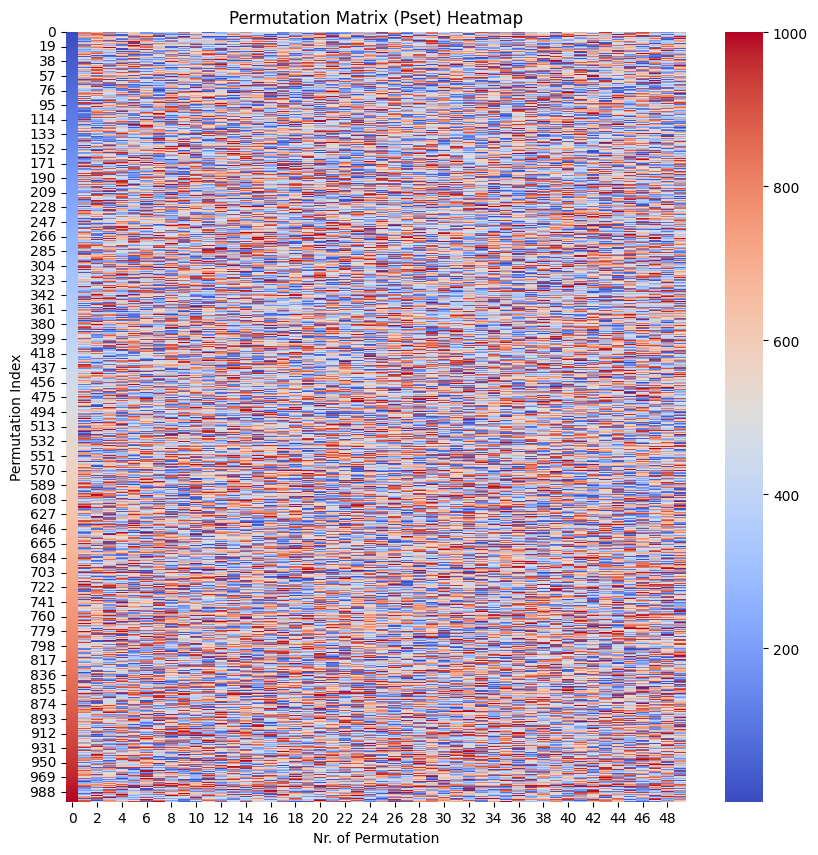

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming Pset is a numpy array
figsize= (10, 10)
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(Pset, cmap='coolwarm', cbar=True)
plt.title('Permutation Matrix (Pset) Heatmap')
plt.xlabel('Nr. of Permutation')
plt.ylabel('Permutation Index')
plt.show()
